# Simple QUIMB test
Created 23/05/2024

Objectives:
* Try out QUIMB on simple cluster model.

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../../")

In [3]:
from itertools import chain
import re

In [4]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [5]:
import numpy as np

import matplotlib.pyplot as plt

In [6]:
import quimb as qu
import quimb.tensor as qtn
from quimb.tensor.optimize import TNOptimizer

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


# Load data

In [7]:
DATA_DIR = r"../../data/transverse_cluster_200_site_dmrg"

In [8]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

In [9]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data))

In [10]:
psi_dict = dict()

In [11]:
for b in b_parameters:
    psi = next(
        d['wavefunction']
        for d in loaded_data
        if d['paramters']['B'] == b
    )

    rounded_b = round(b, 1)
    psi_dict[rounded_b] = psi

In [12]:
psi = psi_dict[0]

In [13]:
from collections import Counter

In [14]:
Counter(
    tuple(psi.get_B(i).get_leg_labels())
    for i in range(psi.L)
)

Counter({('vL', 'p', 'vR'): 200})

In [15]:
psi_arrays = list()
psi_arrays.append(psi.get_B(0, 'Th')[0, ...].to_ndarray())
for i in range(1, psi.L-1):
    psi_arrays.append(psi.get_B(i).to_ndarray())
psi_arrays.append(psi.get_B(psi.L-1)[..., 0].to_ndarray())

In [16]:
q1 = (
    qtn
    .tensor_1d
    .MatrixProductState(
        psi_arrays,
        shape='lpr'
    )
)

In [17]:
np_X = np.array([[0,1],[1,0]])

In [18]:
def generate_problem_rdm(quimb_psi, symmetry_site_pairs, leftmost_symmetry_site,
                         num_symmetry_sites, num_boundary_sites):
    q_top = quimb_psi.copy(deep=True)
    for i, s in symmetry_site_pairs:
        q_top.gate(
            s,
            where=i,
            contract=False,
            inplace=True
        )

    
    indices_to_map = list(chain(
        range(leftmost_symmetry_site-num_boundary_sites, leftmost_symmetry_site),
        range(leftmost_symmetry_site+num_symmetry_sites, leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites)
    ))

    index_mapping = {f'k{i}': f'b{i}' for i in indices_to_map}

    q_bottom = quimb_psi.copy()
    q_bottom.reindex(index_mapping, inplace=True)

    sites_to_contract = {
        'left': list(range(leftmost_symmetry_site-num_boundary_sites)),
        'middle': list(range(leftmost_symmetry_site, leftmost_symmetry_site+num_symmetry_sites)),
        'right': list(range(leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites, quimb_psi.L))
    }

    tags_to_contract = {
        k: [f'I{i}' for i in v]
        for k, v in sites_to_contract.items()
    }

    tn = (q_top & q_bottom)

    tnc = (
        tn
        .contract(tags_to_contract['left'])
        .contract(tags_to_contract['middle'])
        .contract(tags_to_contract['right'])
    )

    return tnc

In [19]:
symmetry_site_pairs = [
    (i, np_X) for i in range(50, 50+100, 2)
]

problem_rdm = generate_problem_rdm(
    q1,
    symmetry_site_pairs,
    50,
    100,
    2
)

## Initial mpos

In [27]:
num_boundary_sites=2
left_most_symmetry_site=50
num_symmetry_sites=100

In [28]:
ml = qtn.MPO_rand(
    num_boundary_sites,
    3,
    phys_dim=2,
    normalize=True,
    sites=list(range(left_most_symmetry_site-num_boundary_sites, left_most_symmetry_site)),
    tags='left_mpo'
)

In [29]:
mr = qtn.MPO_rand(
    num_boundary_sites,
    3,
    phys_dim=2,
    normalize=True,
    sites=list(range(
        left_most_symmetry_site + num_symmetry_sites,
        left_most_symmetry_site + num_symmetry_sites + num_boundary_sites
    )),
    tags='right_mpo'
)

In [30]:
mpo = (ml & mr)

## Optimisation functions

In [31]:
def overlap_loss_function(ml, mr, rdm_tn):
    c = (rdm_tn & ml & mr) ^ ...

    c_abs = abs(c)

    loss = (c_abs - 1)**2

    return loss

In [32]:
total_physical_dim = 4

In [33]:
regex_s = r"^I\d+$"
regex_p = re.compile(regex_s)

In [34]:
def relabel_mpo(mpo, k_label, b_label):
    site_locs = [
        int(k[1:]) for k in mpo.tag_map
        if bool(re.search(regex_p, k))
    ]

    k_in_indices = [f'k{i}' for i in site_locs]
    j_in_indices = [f'b{i}' for i in site_locs]

    k_out_indices = [f'{k_label}{i}' for i in site_locs]
    j_out_indices = [f'{b_label}{i}' for i in site_locs]

    mapping = dict(
        chain(
            zip(k_in_indices, k_out_indices),
            zip(j_in_indices, j_out_indices)
        )
    )

    mpo.reindex(mapping, inplace=True)

In [35]:
def unitarity_tn(tn, total_physical_dim):
    ms = [tn.copy(), tn.copy(), tn.copy()]

    relabel_mpo(ms[0], 'k', 'l')
    relabel_mpo(ms[1], 'm', 'l')
    relabel_mpo(ms[2], 'm', 'b')

    ms[0] = ms[0].conj()
    ms[2] = ms[2].conj()

    n2tn = (tn & tn.conj())
    n2 = n2tn.contract(n2tn.tag_map)
    n4tn = (tn & ms[0] & ms[1] & ms[2])
    n4 = n4tn.contract(n4tn.tag_map)

    return n4 - 2*n2 + total_physical_dim

In [36]:
def overall_loss_function(mpo, rdm_tn, total_physical_dimension,
    unitary_cost_coefficient=1, overlap_cost_coefficient=1, losses=None):
    ml = qtn.TensorNetwork(
        list(map(mpo.tensor_map.__getitem__, mpo.tag_map['left_mpo']))
    )
    mr = qtn.TensorNetwork(
        list(map(mpo.tensor_map.__getitem__, mpo.tag_map['right_mpo']))
    )
    o_loss = overlap_loss_function(ml, mr, rdm_tn)
    ul_loss = unitarity_tn(ml, total_physical_dimension)
    ur_loss = unitarity_tn(mr, total_physical_dimension)

    out = (
        unitary_cost_coefficient*(ul_loss+ur_loss)
        + overlap_cost_coefficient*o_loss
    )

    if losses is not None:
        losses.append((o_loss, ul_loss, ur_loss))
    return out

# Optimization runs

## 1

In [37]:
loss_data=list()

In [39]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': problem_rdm,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 1,
        'overlap_cost_coefficient': 50,
        'losses': loss_data
    },
    autodiff_backend='tensorflow',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='L-BFGS-B',               # supplied to scipy.minimize
)

In [40]:
mpo_opt = optmzr.optimize(1000)

+0.000000448045 [best: +0.000000448045] :  31%|██████████████████████████████████████▏                                                                                   | 313/1000 [00:07<00:15, 42.94it/s]


In [41]:
len(loss_data)

313

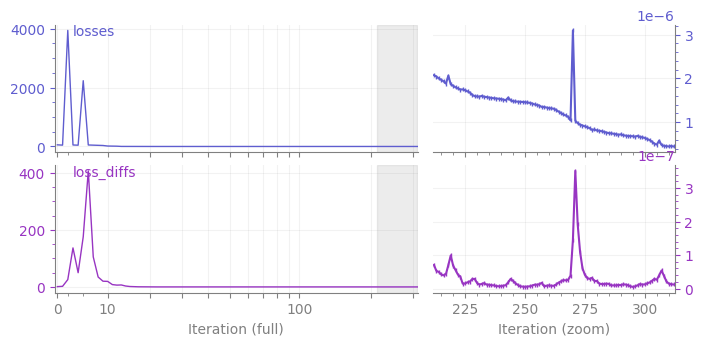

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [42]:
optmzr.plot()

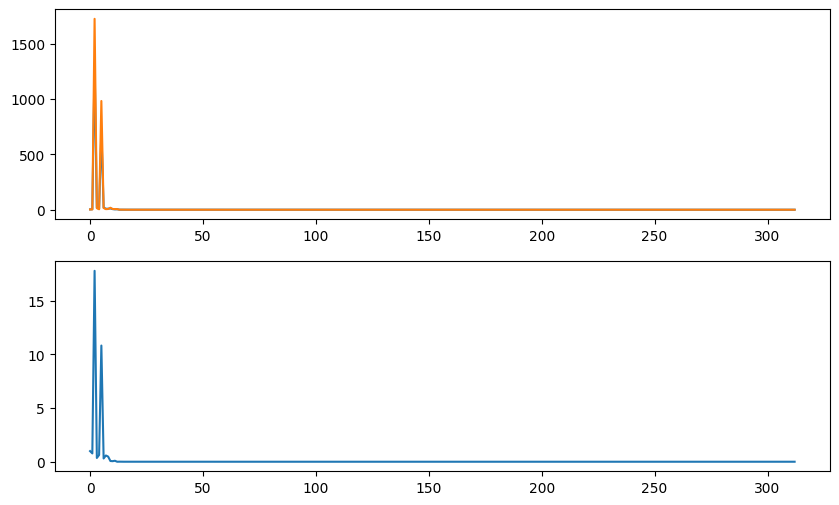

In [50]:
X = np.array(loss_data)

fig, [ax1, ax2] = plt.subplots(nrows=2, figsize=(10, 6))

ax1.plot(X[:,1])
ax1.plot(X[:,2])
ax2.plot(X[:,0])

plt.show()

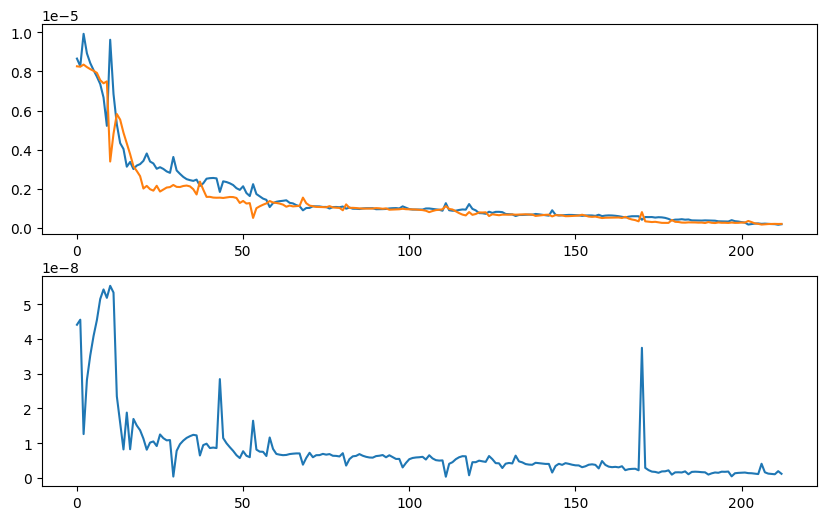

In [53]:
X = np.array(loss_data)[100:]

fig, [ax1, ax2] = plt.subplots(nrows=2, figsize=(10, 6))

ax1.plot(X[:,1])
ax1.plot(X[:,2])
ax2.plot(X[:,0])

plt.show()

## 2
Increase number of sites...?

In [54]:
num_boundary_sites=20

In [55]:
total_physical_dim=2**20

In [56]:
problem_rdm = generate_problem_rdm(
    q1,
    symmetry_site_pairs,
    50,
    100,
    num_boundary_sites
)

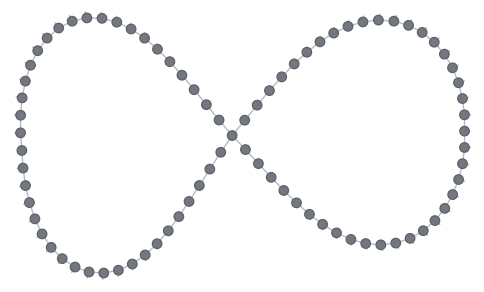

In [57]:
problem_rdm.draw()

In [58]:
ml = qtn.MPO_rand(
    num_boundary_sites,
    5,
    phys_dim=2,
    normalize=True,
    sites=list(range(left_most_symmetry_site-num_boundary_sites, left_most_symmetry_site)),
    tags='left_mpo'
)

In [59]:
mr = qtn.MPO_rand(
    num_boundary_sites,
    5,
    phys_dim=2,
    normalize=True,
    sites=list(range(
        left_most_symmetry_site + num_symmetry_sites,
        left_most_symmetry_site + num_symmetry_sites + num_boundary_sites
    )),
    tags='right_mpo'
)

In [60]:
mpo = (ml & mr)

In [61]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': problem_rdm,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 1,
        'overlap_cost_coefficient': 100,
        'losses': loss_data
    },
    autodiff_backend='tensorflow',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='L-BFGS-B',               # supplied to scipy.minimize
)

In [78]:
mpo_opt = optmzr.optimize(5000)

+169.416456116530 [best: +169.416456116530] : : 5287it [30:17,  2.91it/s]                                                                                                                                   


In [79]:
len(loss_data)

9876

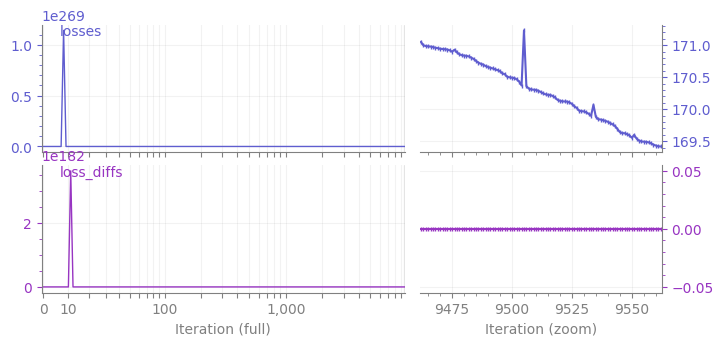

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [80]:
optmzr.plot()

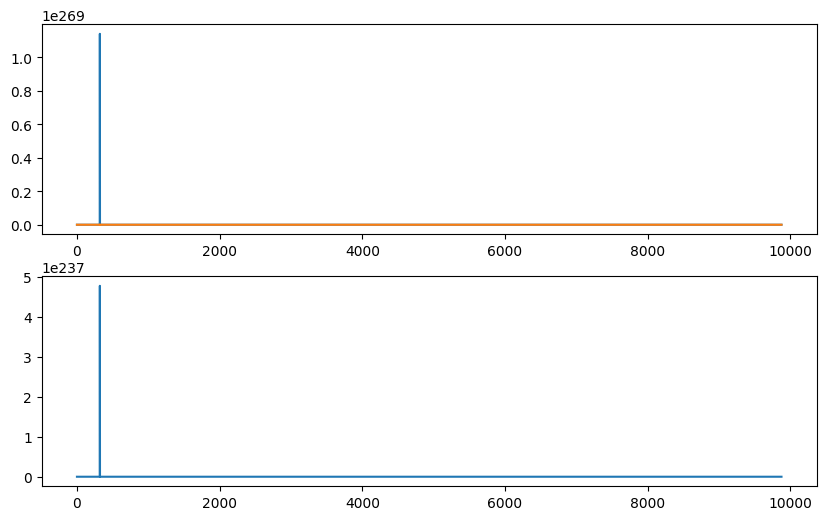

In [81]:
X = np.array(loss_data)

fig, [ax1, ax2] = plt.subplots(nrows=2, figsize=(10, 6))

ax1.plot(X[:,1])
ax1.plot(X[:,2])
ax2.plot(X[:,0])

plt.show()

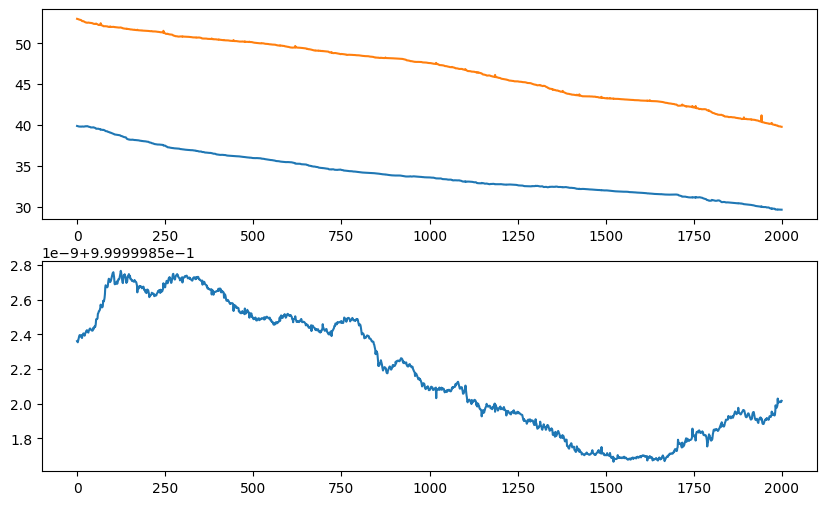

In [82]:
X = np.array(loss_data)[-2000:]

fig, [ax1, ax2] = plt.subplots(nrows=2, figsize=(10, 6))

ax1.plot(X[:,1])
ax1.plot(X[:,2])
ax2.plot(X[:,0])

plt.show()